## Imports

In [1]:
import sys
sys.path.insert(1, "../")

import importlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier

In [2]:
def reload_modules():
    import ghost_unfairness
    importlib.reload(ghost_unfairness.fair_dataset)
    importlib.reload(ghost_unfairness.utils)
    
reload_modules()

from ghost_unfairness.fair_dataset import FairDataset

from ghost_unfairness.utils import *


## Constants

Remeber that after the data is processed, all privileged class values are mapped to 1 and all unprivileged class values are mapped to 0. That means in the following case, after the processing, "Male" will be mapped to 1 and "Female" will be mapped to 0.

In [3]:
protected = ["sex"]
privileged_classes = [['Male']]


privileged_groups = [{key:1 for key in protected}]
unprivileged_groups = [{key:0 for key in protected}]

random_state = 47

## Fair Dataset

In [4]:
fd_train = FairDataset(200, 5, 
                      protected_attribute_names=['sex'],
                      privileged_classes=[['Male']],
                      random_state=random_state)
fd_test = FairDataset(100, 5,
                      protected_attribute_names=['sex'],
                      privileged_classes=[['Male']],
                     random_state=53)

In [5]:
fd_train_x, fd_train_y = fd_train.get_xy(keep_protected = False)
fd_test_x, fd_test_y = fd_test.get_xy(keep_protected = False)

In [6]:
fd_train

               instance weights  features                                  \
                                                                            
                                        0          1          2         3   
instance names                                                              
0                           1.0 -4.240047   6.529532   4.621040  3.202059   
1                           1.0  8.988804  -5.063934   4.118117 -1.473252   
2                           1.0 -6.968635   5.520898  -4.661701 -4.715782   
3                           1.0  3.974791   3.597666   0.438311 -6.613742   
4                           1.0 -9.173976   1.637482   2.381186  0.842143   
...                         ...       ...        ...        ...       ...   
795                         1.0  1.630193   6.475569  12.419428  7.238157   
796                         1.0  3.165066   2.300594   5.007251 -3.545546   
797                         1.0 -1.321106   1.149172   0.448120  4.484917   

In [7]:
fd_test

               instance weights   features                                  \
                                                                             
                                         0         1          2          3   
instance names                                                               
0                           1.0   1.029324  5.833809 -10.363199  -3.163436   
1                           1.0  11.972769 -2.706168   3.763527 -10.751759   
2                           1.0  -2.009480 -3.060163  -0.617044  -2.640602   
3                           1.0 -10.309444  8.670462  -5.280903   9.030121   
4                           1.0  11.990397  2.714512  -1.138189  -1.362028   
...                         ...        ...       ...        ...        ...   
395                         1.0  -0.167737  3.480864   9.339217   0.988786   
396                         1.0   0.041595 -1.696571  -9.141079   0.683286   
397                         1.0   0.757425  6.015287  -1.562775 

In [8]:
get_dataset_metrics(fd_train,
                    unprivileged_groups,
                    privileged_groups, 
                    verbose=True)

Mean Difference: 0.0
Dataset Base Rate 0.5
Privileged Base Rate 0.5
Protected Base Rate 0.5
Disparate Impact: 1.0


(0.0, 1.0)

### Training Logistic Regression

In [9]:
lmod = LogisticRegression(class_weight='balanced', 
                          solver='liblinear',
                         verbose=2)
lmod.fit(fd_train_x, fd_train_y)

[LibLinear]

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=2,
                   warm_start=False)

In [10]:
get_classifier_metrics(lmod, fd_test,
                       privileged_groups, 
                       unprivileged_groups, 
                       verbose=True)

Mean Difference: 0.08000000000000002
Disparate Impact: 0.17582417582417587
Accuracy: 0.775


[0.08000000000000002, 1.1758241758241759, 0.775, 0.785, 0.765]

### Training Decision Tree

In [11]:
dmod = DecisionTreeClassifier(criterion='entropy', 
                                   max_depth=40,
                                  random_state=47)
dmod = dmod.fit(fd_train_x, fd_train_y)

get_classifier_metrics(dmod, fd_test, 
                       privileged_groups, 
                       unprivileged_groups, 
                       verbose=True)

print('Tree Depth:', dmod.get_depth())

Mean Difference: 0.04999999999999999
Disparate Impact: 0.11363636363636354
Accuracy: 0.65
Tree Depth: 23


### Variation of fairness with model complexity

In [12]:
def train_model_variants(model_type, fd, variant, values,
                        params):
    fd_x, fd_y = fd.get_xy(keep_protected=False)
    models = []
    for val in values:
        model = model_type()
        params[variant] = val
        model.set_params(**params)

        model = model.fit(fd_x, fd_y)
        models.append(model)
        
    return models

In [13]:
def get_model_results(model, train_fd, test_fd, func=None):
    if func:
        model_property = func(model)
    else:
        model_property = None
    
    metrics = get_classifier_metrics(model, train_fd,
                                        privileged_groups, 
                                        unprivileged_groups, 
                                        verbose=True)
    train_result = (*metrics, model_property)
    
    print('Test')
    
    metrics = get_classifier_metrics(model, test_fd,
                                        privileged_groups, 
                                        unprivileged_groups,
                                       verbose=True)
    test_result = (*metrics, model_property)
    
    return train_result, test_result

In [14]:
def get_results(models, train_fd, test_fd, func=None):
    train_results = []
    test_results = []
    for model in models:
        train_result, test_result = get_model_results(model, train_fd, 
                                                      test_fd, func)
        train_results.append(train_result)
        test_results.append(test_result)
        
    return train_results, test_results

In [15]:
def decision_tree_property(model):
    return {'depth': model.get_depth()}

In [16]:
max_depths = [3, 5, 10, 15, 20, 25]

params = {'criterion':'entropy',
          'random_state': 47}
variant = 'max_depth'
dmods = train_model_variants(DecisionTreeClassifier,
                            fd_train, variant, max_depths,
                            params)

train_results, test_results = get_results(dmods, fd_train, fd_test,
                                         decision_tree_property)


Mean Difference: 0.07250000000000001
Disparate Impact: 0.16384180790960445
Accuracy: 0.71625
Test
Mean Difference: 0.02999999999999997
Disparate Impact: 0.06382978723404253
Accuracy: 0.59
Mean Difference: 0.05500000000000005
Disparate Impact: 0.1170212765957448
Accuracy: 0.78
Test
Mean Difference: 0.015000000000000013
Disparate Impact: 0.030612244897959218
Accuracy: 0.6425
Mean Difference: 0.022499999999999964
Disparate Impact: 0.048648648648648596
Accuracy: 0.91125
Test
Mean Difference: 0.010000000000000009
Disparate Impact: 0.024096385542168752
Accuracy: 0.645
Mean Difference: 0.020000000000000018
Disparate Impact: 0.040000000000000036
Accuracy: 0.985
Test
Mean Difference: 0.010000000000000009
Disparate Impact: 0.02083333333333326
Accuracy: 0.64
Mean Difference: 0.0050000000000000044
Disparate Impact: 0.010152284263959421
Accuracy: 0.995
Test
Mean Difference: 0.044999999999999984
Disparate Impact: 0.10227272727272729
Accuracy: 0.6425
Mean Difference: 0.0
Disparate Impact: 0.0
Accurac

In [17]:
train_results

[(0.07250000000000001, 1.1638418079096045, 0.71625, 0.7325, 0.7, {'depth': 3}),
 (0.05500000000000005, 1.1170212765957448, 0.78, 0.785, 0.775, {'depth': 5}),
 (0.022499999999999964,
  1.0486486486486486,
  0.91125,
  0.8975,
  0.925,
  {'depth': 10}),
 (0.020000000000000018, 1.04, 0.985, 0.995, 0.975, {'depth': 15}),
 (0.0050000000000000044,
  1.0101522842639594,
  0.995,
  0.9925,
  0.9975,
  {'depth': 20}),
 (0.0, 1.0, 1.0, 1.0, 1.0, {'depth': 23})]

In [18]:
test_results

[(-0.02999999999999997, 0.9361702127659575, 0.59, 0.62, 0.56, {'depth': 3}),
 (-0.015000000000000013,
  0.9693877551020408,
  0.6425,
  0.65,
  0.635,
  {'depth': 5}),
 (0.010000000000000009,
  1.0240963855421688,
  0.645,
  0.645,
  0.645,
  {'depth': 10}),
 (0.010000000000000009, 1.0208333333333333, 0.64, 0.66, 0.62, {'depth': 15}),
 (0.044999999999999984,
  1.1022727272727273,
  0.6425,
  0.66,
  0.625,
  {'depth': 20}),
 (0.04999999999999999, 1.1136363636363635, 0.65, 0.67, 0.63, {'depth': 23})]

Increasing model complexity tends to increase the disparate impact and mean difference at some point.

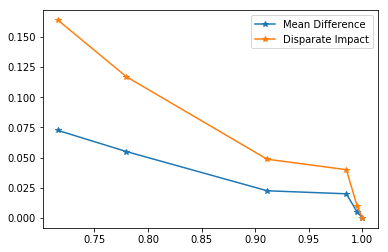

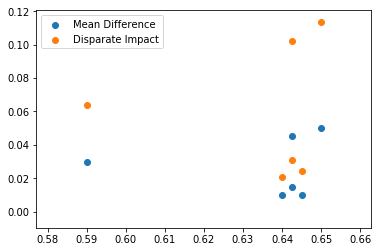

In [19]:
def plot_acc_vs_metric(results, plot_type='line'):
    mds = [abs(tup[0]) for tup in results]
    dis = [abs(1 - tup[1]) for tup in results]
    acs = [tup[2] for tup in results]
    tds = [tup[3] for tup in results]
    
    if plot_type == 'line':
        plt.plot(acs, mds, '*-', label='Mean Difference')
        plt.plot(acs, dis, '*-', label='Disparate Impact')
    elif plot_type == 'scatter':
        plt.scatter(acs, mds, label='Mean Difference')
        plt.scatter(acs, dis, label='Disparate Impact')        
    plt.legend()
    
plot_acc_vs_metric(train_results)
plt.show()
plot_acc_vs_metric(test_results, 'scatter')
plt.show()

Same characteristic can also be seen in the test dataset as well. Trying to increase accuracy in the test dataset also increases the disparate impact and mean difference.

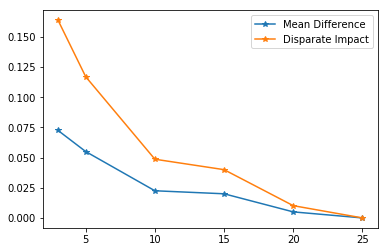

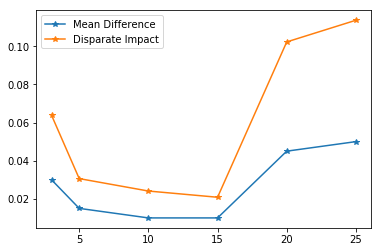

In [20]:
def plot_complexity_vs_metric(results, params):
    mds = [abs(tup[0]) for tup in results]
    dis = [abs(1-tup[1]) for tup in results]
    acs = [tup[2] for tup in results]
    tds = [tup[3] for tup in results]

    plt.plot(params, mds, '*-', label='Mean Difference')
    plt.plot(params, dis, '*-', label='Disparate Impact')
    plt.legend()
    
    
plot_complexity_vs_metric(train_results, max_depths)
plt.show()
plot_complexity_vs_metric(test_results, max_depths)

We want to see group wise accuracy rates for the models.

In [21]:
%%capture --no-stdout
acc_diffs = [tup[3] - tup[4] for tup in train_results]
print(acc_diffs)

[0.032500000000000084, 0.010000000000000009, -0.02750000000000008, 0.020000000000000018, -0.0050000000000000044, 0.0]


#### The accuracy difference between privileged and unprivileged groups on the training dataset shows similar trend to the training dataset disparate impact.

Therefore, we want to claim that while training, one group is picked over the other as a winner even though they have same ratio of positive and negative samples.

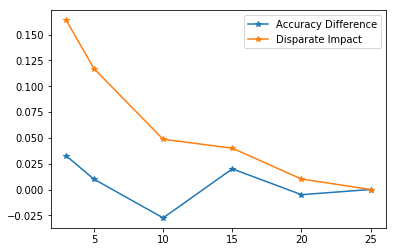

[(0.07250000000000001, 1.1638418079096045, 0.71625, 0.7325, 0.7, {'depth': 3}), (0.05500000000000005, 1.1170212765957448, 0.78, 0.785, 0.775, {'depth': 5}), (0.022499999999999964, 1.0486486486486486, 0.91125, 0.8975, 0.925, {'depth': 10}), (0.020000000000000018, 1.04, 0.985, 0.995, 0.975, {'depth': 15}), (0.0050000000000000044, 1.0101522842639594, 0.995, 0.9925, 0.9975, {'depth': 20}), (0.0, 1.0, 1.0, 1.0, 1.0, {'depth': 23})]
[0.032500000000000084, 0.010000000000000009, -0.02750000000000008, 0.020000000000000018, -0.0050000000000000044, 0.0]


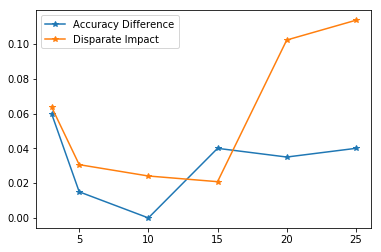

[(-0.02999999999999997, 0.9361702127659575, 0.59, 0.62, 0.56, {'depth': 3}), (-0.015000000000000013, 0.9693877551020408, 0.6425, 0.65, 0.635, {'depth': 5}), (0.010000000000000009, 1.0240963855421688, 0.645, 0.645, 0.645, {'depth': 10}), (0.010000000000000009, 1.0208333333333333, 0.64, 0.66, 0.62, {'depth': 15}), (0.044999999999999984, 1.1022727272727273, 0.6425, 0.66, 0.625, {'depth': 20}), (0.04999999999999999, 1.1136363636363635, 0.65, 0.67, 0.63, {'depth': 23})]
[0.05999999999999994, 0.015000000000000013, 0.0, 0.040000000000000036, 0.03500000000000003, 0.040000000000000036]


In [22]:
%%capture --no-stdout --no-display
def plot_accuracy_diffrences(results, acc_diffs, values):
    dis = [abs(1 - tup[1]) for tup in results] 
    plt.plot(values, acc_diffs, '*-', label='Accuracy Difference')
    plt.plot(values, dis, '*-', label='Disparate Impact')
    plt.legend()
    
acc_diffs = [tup[3] - tup[4] for tup in train_results]
plot_accuracy_diffrences(train_results, acc_diffs, max_depths)
plt.show()
print(train_results)
print(acc_diffs)
acc_diffs = [tup[3] - tup[4] for tup in test_results]
plot_accuracy_diffrences(test_results, acc_diffs, max_depths)
plt.show()
print(test_results)
print(acc_diffs)

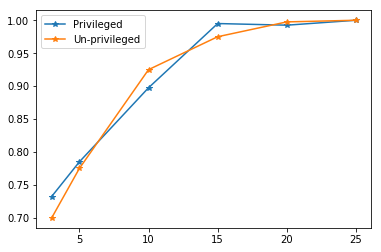

In [23]:
acs_p = [tup[3] for tup in train_results]
acs_u = [tup[4] for tup in train_results]
plt.plot(max_depths, acs_p, '*-', label='Privileged')
plt.plot(max_depths, acs_u, '*-', label='Un-privileged')
plt.legend()

### Training with reqularization parameter

In [24]:
def logistic_reg_property(model):
    # TODO: will return theta from this function.
    return {}

In [25]:
regularizers = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

params = {'class_weight': 'balanced',
          'solver': 'liblinear'}
variant = 'C'
lmods = train_model_variants(LogisticRegression,
                            fd_train, variant, regularizers,
                            params)

lr_train_results, lr_test_results = get_results(lmods, fd_train, fd_test,
                                                logistic_reg_property)


Mean Difference: 0.05500000000000005
Disparate Impact: 0.08118081180811809
Accuracy: 0.695
Test
Mean Difference: 0.040000000000000036
Disparate Impact: 0.05797101449275366
Accuracy: 0.705
Mean Difference: 0.0625
Disparate Impact: 0.09363295880149813
Accuracy: 0.69875
Test
Mean Difference: 0.039999999999999925
Disparate Impact: 0.058394160583941535
Accuracy: 0.705
Mean Difference: 0.07500000000000007
Disparate Impact: 0.11673151750972766
Accuracy: 0.7125
Test
Mean Difference: 0.06499999999999995
Disparate Impact: 0.10077519379844957
Accuracy: 0.7025
Mean Difference: 0.08250000000000002
Disparate Impact: 0.15068493150684925
Accuracy: 0.73625
Test
Mean Difference: 0.08000000000000007
Disparate Impact: 0.14159292035398252
Accuracy: 0.75
Mean Difference: 0.05249999999999999
Disparate Impact: 0.1071428571428572
Accuracy: 0.76375
Test
Mean Difference: 0.06500000000000006
Disparate Impact: 0.13541666666666674
Accuracy: 0.7725
Mean Difference: 0.05999999999999994
Disparate Impact: 0.12834224598

In [26]:
print(lr_train_results)
lr_test_results

[(0.05500000000000005, 1.081180811808118, 0.695, 0.7175, 0.6725, {}), (0.0625, 1.0936329588014981, 0.69875, 0.7225, 0.675, {}), (0.07500000000000007, 1.1167315175097277, 0.7125, 0.7425, 0.6825, {}), (0.08250000000000002, 1.1506849315068493, 0.73625, 0.7475, 0.725, {}), (0.05249999999999999, 1.1071428571428572, 0.76375, 0.77, 0.7575, {}), (0.05999999999999994, 1.1283422459893047, 0.7775, 0.7875, 0.7675, {}), (0.057499999999999996, 1.1229946524064172, 0.77875, 0.7875, 0.77, {}), (0.057499999999999996, 1.1229946524064172, 0.77875, 0.7875, 0.77, {})]


[(0.040000000000000036, 1.0579710144927537, 0.705, 0.7, 0.71, {}),
 (0.039999999999999925, 1.0583941605839415, 0.705, 0.705, 0.705, {}),
 (0.06499999999999995, 1.1007751937984496, 0.7025, 0.705, 0.7, {}),
 (0.08000000000000007, 1.1415929203539825, 0.75, 0.755, 0.745, {}),
 (0.06500000000000006, 1.1354166666666667, 0.7725, 0.78, 0.765, {}),
 (0.08000000000000002, 1.1758241758241759, 0.775, 0.785, 0.765, {}),
 (0.08000000000000002, 1.1758241758241759, 0.775, 0.785, 0.765, {}),
 (0.08000000000000002, 1.1758241758241759, 0.775, 0.785, 0.765, {})]

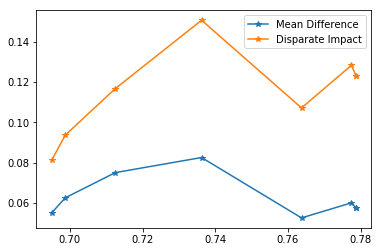

In [27]:
plot_acc_vs_metric(lr_train_results)

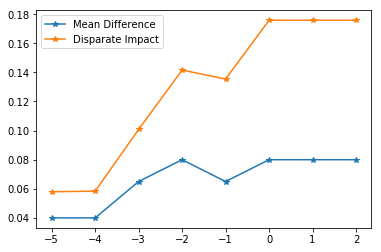

In [28]:
plot_complexity_vs_metric(lr_test_results, np.log10(regularizers))

[0.04500000000000004, 0.04749999999999999, 0.06000000000000005, 0.022500000000000075, 0.012500000000000067, 0.020000000000000018, 0.01749999999999996, 0.01749999999999996]


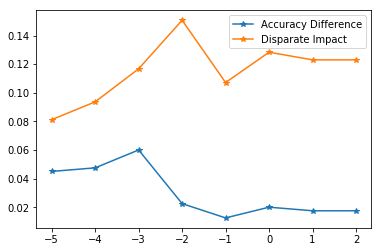

In [29]:
%%capture --no-stdout --no-display
acc_diffs = [tup[3] - tup[4] for tup in lr_train_results]
plot_accuracy_diffrences(lr_train_results, acc_diffs, np.log10(regularizers))
print(acc_diffs)

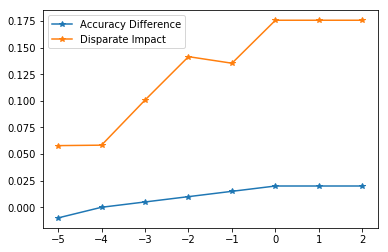

In [30]:
acc_diffs = [tup[3] - tup[4] for tup in lr_test_results]
plot_accuracy_diffrences(lr_test_results, acc_diffs, np.log10(regularizers))

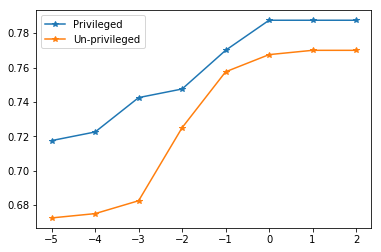

In [31]:
acs_p = [tup[3] for tup in lr_train_results]
acs_u = [tup[4] for tup in lr_train_results]
plt.plot(np.log10(regularizers), acs_p, '*-', label='Privileged')
plt.plot(np.log10(regularizers), acs_u, '*-', label='Un-privileged')
plt.legend()

Does test measures average out?

[[0.01625    0.0335094  0.640875  ]
 [0.02975    0.05792123 0.668375  ]
 [0.03025    0.06244493 0.659375  ]
 [0.0255     0.0506964  0.6495    ]
 [0.02475    0.0514518  0.651125  ]
 [0.0225     0.04626932 0.65175   ]]
[[0.00853302 0.01807073 0.01749152]
 [0.01708252 0.03291758 0.01843104]
 [0.01663768 0.03266402 0.02213771]
 [0.01942292 0.03671219 0.01319564]
 [0.0165246  0.03294098 0.01952922]
 [0.01799305 0.03586238 0.01947916]]


<ErrorbarContainer object of 3 artists>

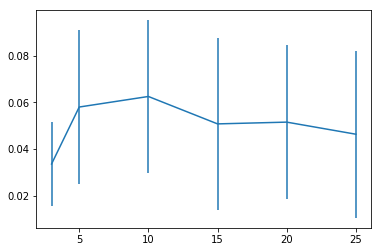

In [40]:
test_fds = []
for i in range(10):
    temp_fd = FairDataset(200, 5,
                          protected_attribute_names=['sex'],
                          privileged_classes=[['Male']],
                          random_state=i)
    test_fds.append(temp_fd)
    # print(temp_fd)
    
    
results = []
for i in range(len(dmods)):
    results.append([])
    for fd in test_fds:
        md, di, acc, _, _ = get_classifier_metrics(dmods[i], fd,
                                             privileged_groups=privileged_groups,
                                             unprivileged_groups=unprivileged_groups)
               
        
        results[i] += [[abs(md), abs(1-di), acc]]
    
    # print(results[i])

    
results = np.array(results)
means = np.mean(results, axis=1)
variations = np.std(results, axis=1)
# print(results)
print(means)
print(variations)
plt.errorbar(max_depths, means[:, 1], yerr=variations[:, 1])

### Bayes Model

In [34]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(fd_train_x, fd_train_y)

gnb_results = []
for fd in test_fds:
    gnb_results.append(get_classifier_metrics(gnb, fd, 
                                 privileged_groups, 
                                 unprivileged_groups))
    print(gnb_results[-1])

[0.020000000000000018, 1.0394088669950738, 0.7525, 0.7575, 0.7475]
[0.0, 1.0, 0.735, 0.745, 0.725]
[-0.007500000000000007, 0.9846938775510204, 0.74125, 0.74, 0.7425]
[0.012500000000000011, 1.0261780104712042, 0.73375, 0.7175, 0.75]
[0.04500000000000004, 1.0927835051546393, 0.7375, 0.715, 0.76]
[-0.03750000000000003, 0.9299065420560747, 0.73375, 0.77, 0.6975]
[0.007499999999999951, 1.0142857142857142, 0.74875, 0.755, 0.7425]
[-0.019999999999999962, 0.9605911330049262, 0.7475, 0.7525, 0.7425]
[0.030000000000000027, 1.0612244897959184, 0.74, 0.72, 0.76]
[-0.0050000000000000044, 0.9898477157360406, 0.7175, 0.7175, 0.7175]


In [35]:
print('Standard Deviation for Bayes classifier Disparate Impact:')
print(np.std([abs(1-tup[1])for tup in gnb_results]))
print(np.mean([abs(1-tup[1])for tup in gnb_results]))

Standard Deviation for Bayes classifier Disparate Impact:
0.028282064518514925
0.03688413183544881


In [36]:
gnb.theta_

array([[ 3.117459  ,  3.0689007 ,  3.20912826,  2.99149403,  2.84899228],
       [-0.16726231, -0.09178117, -0.12160162,  0.01981995, -0.0639545 ]])

In [37]:
np.sqrt(gnb.sigma_)

array([[5.00807665, 4.81008992, 4.88032196, 4.93532517, 4.88925071],
       [5.13192797, 5.05348721, 5.00905063, 4.8903435 , 5.27688241]])